# Background

The data was obtained from Kaggle (https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis) with a CC0: Public Domain license. The data was inspected, features were created/modified and outliers removed. The created features/modified were:

Created:
- Customer Age
- Total Expenses
- Seniority
- Child Count (Number of Children)
- Has Child (Boolean for children)

Modified:
- Marital Status
- Education

Outliers were removed using scatterplots and boxplots with visual inspection. The prepared data was pickled along with the features to be used for clustering in a list. Pearson correlations were also calculated and the following was determined:

- Income vs Expenses are correlated positively (+0.83)
- Children vs Income (-0.35) and Children vs Expenses (-0.5) are negativly correlated

The rest show little to no correlation. Previous PCA indicated the Seniority and Recency are not important to the model.

# Goal

Apply K-means and PCA to segment the data based on the features to use excluding seniority and recency.

# Imports

In [1]:
# data tools
import numpy as np
import pandas as pd
import pickle as pkl


# inspection tools
# from IPython.core.display import HTML
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing

# date handling
# import datetime
# from datetime import date

# graphing
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
sns.set()

# machine learning
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# import warnings
# warnings.filterwarnings('ignore')

# Functions



In [2]:
# Function to display informative elbow method for clusters

def test_clusters(X, random_state, max_clusters, metric='distortion'):
    model = KMeans(random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    if metric == 'distortion':
        elb_visualiser = KElbowVisualizer(model, k=(1,max_clusters), metric=metric)
    else:
        elb_visualiser = KElbowVisualizer(model, k=(2,max_clusters), metric=metric)
    elb_visualiser.fit(X)
    return elb_visualiser.show()

# Function to display informative silhouette method for clusters

def silhouette_clusters(X, random_state, number_of_clusters):
    model = KMeans(n_clusters=number_of_clusters, random_state=random_state, n_init=10, max_iter=300, tol=1e-04, init='k-means++')
    
    sil_visualiser = SilhouetteVisualizer(model)
    sil_visualiser.fit(X)
    return sil_visualiser.show()

# Function to perform PCA analysis
def pca_analysis(X, num_components):
    if num_components == 'find':
        pca = PCA()
        pca.fit(X)
    else:
        pca = PCA(n_components=num_components)
        pca.fit(X)
    return pca

# function to get component loadings from PCA
def get_comp_loadings(pca_components, cols, index):
    df_pca_comp = pd.DataFrame(data = pca_components, columns=cols, index = index)
    return df_pca_comp


# Load Data

In [3]:
with open('customer_data_without_outliers.pickle', 'rb') as handle:
    dict = pkl.load(handle)

In [4]:
dict['cluster_features']

['Income',
 'Recency',
 'Customer Age',
 'Total Expenses',
 'Seniority',
 'Children']

In [5]:
# Unpack the data
data = dict['data']
features = ['Income',
            #'Recency',
            #'Customer Age',
            'Total Expenses',
            'Seniority',
            'Children']

#  Select clustering features
segm_data = data[features].copy()
segm_data

,Income,Total Expenses,Seniority,Children
ID,,,,
5524,58138.0,1617,25.333333,0
2174,46344.0,27,7.000000,2
4141,71613.0,776,13.633333,0
6182,26646.0,53,7.866667,1
5324,58293.0,422,8.600000,1
...,...,...,...,...
10870,61223.0,1341,15.933333,1
4001,64014.0,444,3.866667,3
7270,56981.0,1241,8.400000,0


# Scale the data

In [6]:
# Use standard scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(segm_data)

# Normalisation
# X_norm = normalize(X_std,norm='l2')

X = X_scaled.copy()

# PCA

In [7]:
# get the components
pca = pca_analysis(X, 'find')

#show the number of components
pca.components_.shape

(4, 4)

In [8]:
number_of_components = pca.components_.shape[0]

Text(0, 0.5, 'Cumulative Explained Varience')

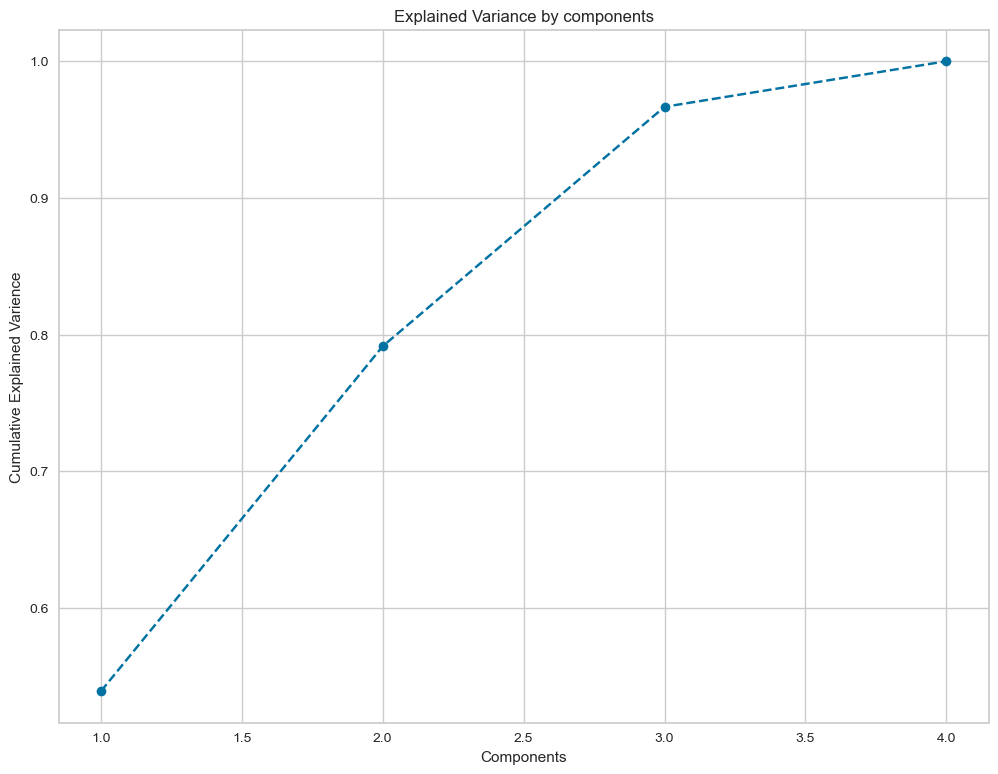

In [9]:
# Plot cumulative variance vs components

plt.figure(figsize=(12,9))
plt.plot(range(1, number_of_components+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle = '--')
plt.title("Explained Variance by components")
plt.xlabel("Components")
plt.ylabel("Cumulative Explained Varience")

70-80% Explained varience is a good benchmark, we can reduce the dimensionality to 2 components

In [10]:
Number_of_components_to_use = 2
pca = pca_analysis(X, Number_of_components_to_use)

## PCA Results

In [11]:
pca_comp = get_comp_loadings(pca.components_, features, ['Component 1', 'Component 2'])
pca_comp

,Income,Total Expenses,Seniority,Children
Component 1,0.601404,0.644734,0.086945,-0.463758
Component 2,0.148961,-0.049940,-0.985692,-0.061051


### PCA pearson correlations to features

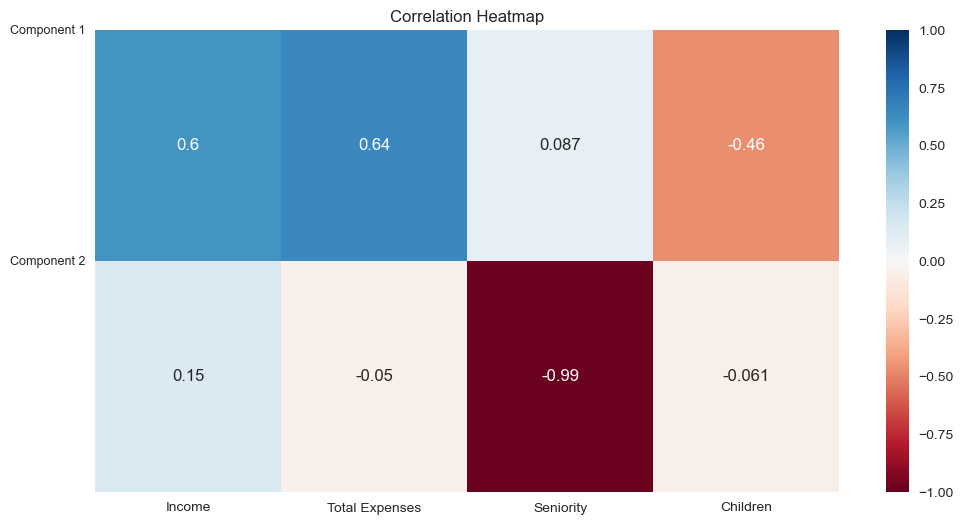

In [12]:
plt.figure(figsize=(12,6))
s = sns.heatmap(pca_comp,
               annot=True,
               cmap='RdBu',
               vmin=-1,
               vmax=1)
plt.yticks([0,1], ['Component 1', 'Component 2'], rotation = 0, fontsize = 9)
plt.title("Correlation Heatmap")
plt.show()

It seems that Component 1 is positively correlated to Income (0.60) and Total Expenses (0.64) whilst negatively correlated with the number of children (-0.46). Component 2 seems negativly correlated with Seniority (-0.99)

The rest are loosely correlated.

In [13]:
# get the PCA scores
scores_pca = pca.transform(X)
scores_pca

array([[ 1.99387731, -1.46502434],
       [-1.52881928,  1.09673883],
       [ 1.3338458 ,  0.41094473],
       ...,
       [ 1.33885413,  1.03115431],
       [ 0.65065901,  1.06631716],
       [-0.96471046, -1.34639823]])

# Hierarchical Clustering


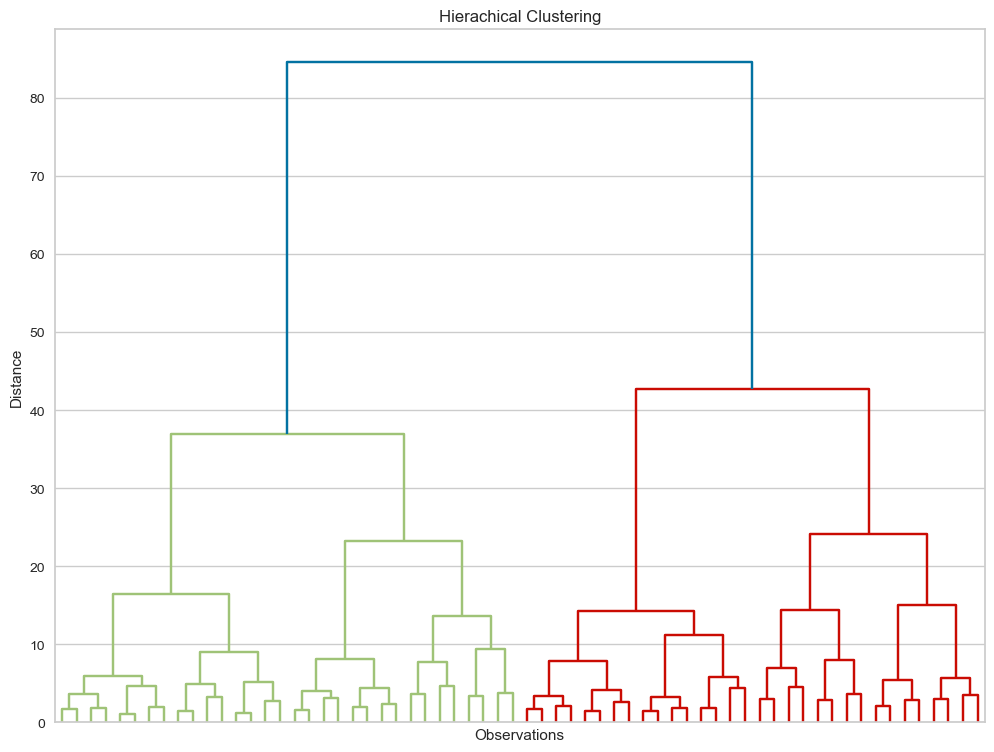

In [14]:
hier_clus = linkage(scores_pca, method='ward')

plt.figure(figsize=(12, 9))
plt.title("Hierachical Clustering")
plt.xlabel("Observations")
plt.ylabel("Distance")
dendrogram(hier_clus,
           truncate_mode='level',
           p=5,
           show_leaf_counts=False,
           no_labels=True,
           # color_threshold=0
           )
plt.show()

# K-means
## Choosing number of clusters

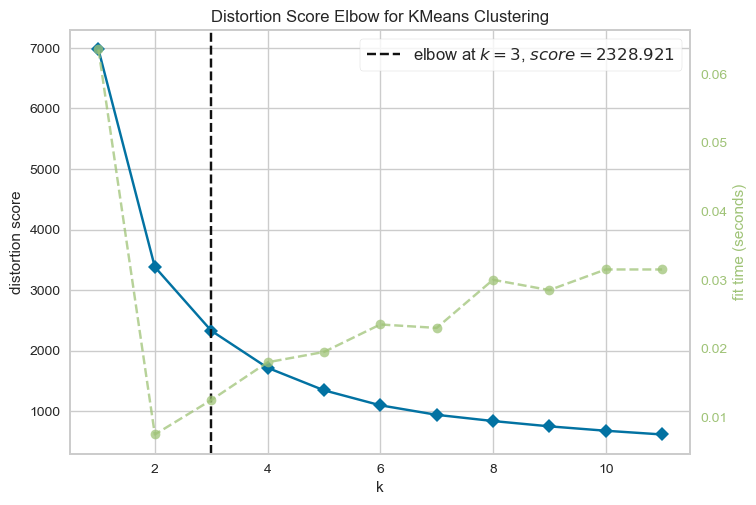

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='distortion')

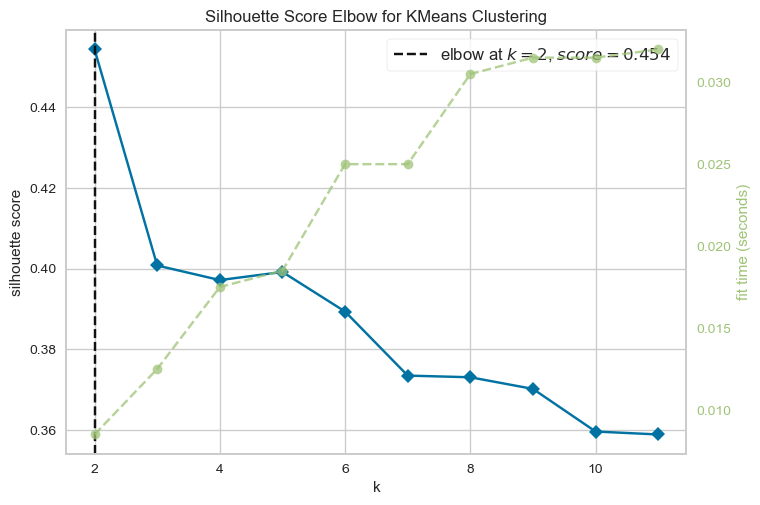

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
test_clusters(X=scores_pca, random_state=1, max_clusters=12, metric='silhouette')

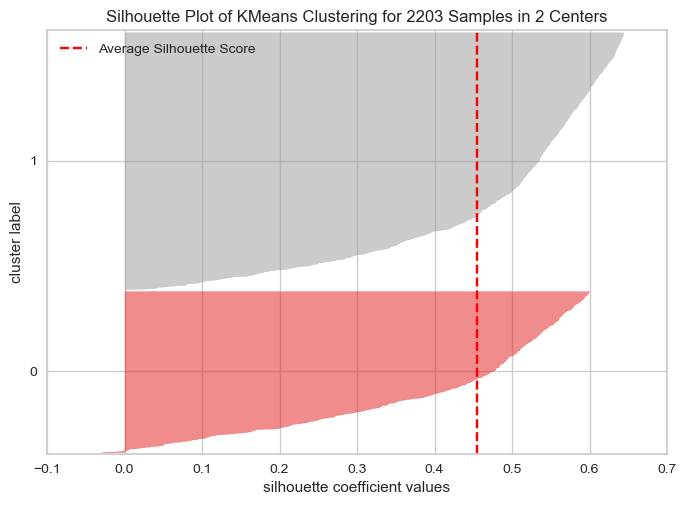

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=2)

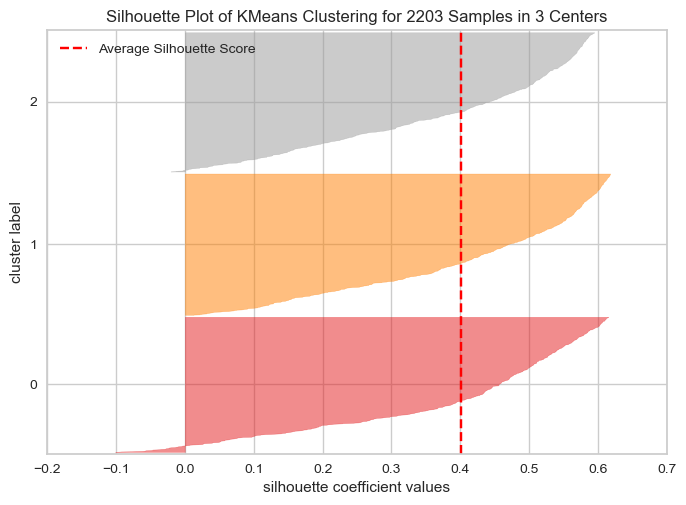

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [18]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=3)

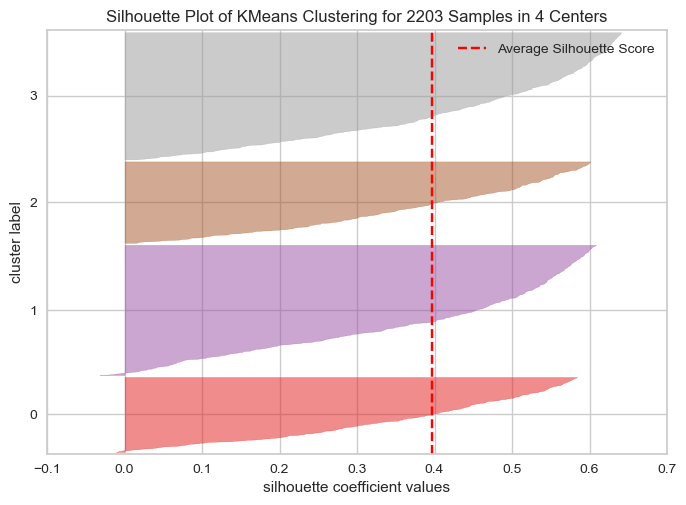

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 2203 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
silhouette_clusters(X=scores_pca, random_state=1, number_of_clusters=4)

## Cluster selection

The number of clusters to select seem to point to choosing 2 clusters. This is based on the Silhoette score as well as the Dendrogram. We could choose 3 based on the elbow method, however often a simpler model is best. We will compare them side by side


In [20]:
# choose two clusters and fit
kmeans_2_clus = KMeans(n_clusters=2, init='k-means++', random_state=1)
kmeans_2_clus.fit(scores_pca)

KMeans(n_clusters=2, random_state=1)

In [21]:
# choose three clusters and fit
kmeans_3_clus = KMeans(n_clusters=3, init='k-means++', random_state=1)
kmeans_3_clus.fit(scores_pca)


KMeans(n_clusters=3, random_state=1)

In [22]:
# choose two clusters and fit
kmeans_4_clus = KMeans(n_clusters=4, init='k-means++', random_state=1)
kmeans_4_clus.fit(scores_pca)

KMeans(n_clusters=4, random_state=1)

## Results PCA K-means

In [23]:
# Copying unscaled data and merging with PCA components for 2, 3 and 4 clusters
segm_pca_kmeans_2_clus = pd.concat([segm_data[features].reset_index(drop=False),
                                    pd.DataFrame(scores_pca)], axis=1)
segm_pca_kmeans_2_clus.columns.values[-2:] = ['Component 1',
                                              'Component 2',
                                             ]
segm_pca_kmeans_3_clus = segm_pca_kmeans_2_clus.copy()
segm_pca_kmeans_4_clus = segm_pca_kmeans_2_clus.copy()

# copy the labels from the models
segm_pca_kmeans_2_clus['Segment K-means PCA'] = kmeans_2_clus.labels_
segm_pca_kmeans_3_clus['Segment K-means PCA'] = kmeans_3_clus.labels_
segm_pca_kmeans_4_clus['Segment K-means PCA'] = kmeans_4_clus.labels_

# Calculate the means per cluster
segm_pca_kmeans_2_clus_means = segm_pca_kmeans_2_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_3_clus_means = segm_pca_kmeans_3_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)
segm_pca_kmeans_4_clus_means = segm_pca_kmeans_4_clus.groupby(
    ['Segment K-means PCA']).mean().reset_index(drop=False)

# Calculate the number of observations
segm_pca_kmeans_2_clus_means['N Obs'] = segm_pca_kmeans_2_clus[[
    'Segment K-means PCA', 'Income']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_3_clus_means['N Obs'] = segm_pca_kmeans_3_clus[[
    'Segment K-means PCA', 'Income']].groupby(['Segment K-means PCA']).count()
segm_pca_kmeans_4_clus_means['N Obs'] = segm_pca_kmeans_4_clus[[
    'Segment K-means PCA', 'Income']].groupby(['Segment K-means PCA']).count()

# Calculate the percentage of observations
segm_pca_kmeans_2_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_2_clus_means['N Obs']/segm_pca_kmeans_2_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_3_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_3_clus_means['N Obs']/segm_pca_kmeans_3_clus_means['N Obs'].sum())*100).round(2)
segm_pca_kmeans_4_clus_means['Percent Obs'] = (
    (segm_pca_kmeans_4_clus_means['N Obs']/segm_pca_kmeans_4_clus_means['N Obs'].sum())*100).round(2)

In [24]:
segm_pca_kmeans_2_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_2_clus_means

,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
0,0,71949.798349,1260.646226,15.895715,0.449292,1.614321,0.006061,848,38.49
1,1,38890.855351,197.053137,14.481722,1.261993,-1.010291,-0.003793,1355,61.51


In [25]:
segm_pca_kmeans_3_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_3_clus_means

,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
0,0,74239.666201,1333.927374,15.459544,0.349162,1.815956,0.088362,716,32.5
1,1,41256.628838,186.356475,9.013307,1.281709,-1.035515,0.811276,749,34.0
2,2,40181.195122,327.048780,20.707724,1.193767,-0.710873,-0.909096,738,33.5


In [26]:
segm_pca_kmeans_4_clus_means.drop("ID", axis = 1, inplace=True)
segm_pca_kmeans_4_clus_means

,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
0,0,73354.596491,1158.556391,9.151629,0.393484,1.493432,1.014270,399,18.11
1,1,38490.357864,270.725830,20.463444,1.202020,-0.828768,-0.881609,693,31.46
2,2,71732.656682,1355.949309,21.150614,0.481567,1.757906,-0.773586,434,19.70
3,3,39344.553914,144.277696,8.995963,1.317578,-1.158751,0.800588,677,30.73


It seems that choosing 2 clusters result in a 40/60 split in the data. However choosing 3 clusters results in a more homogeous split. Choosing 4 clusters becomes non-homogenous again. In general we can find better sepration in Semiority and children with more clusters which also gives more divisions for Income and spending.

Assuming 2 clusters we observe the following on average:

- Cluster 0 = High income, High Expenses, zero to 1 child = Career focused, Well-off
- Cluster 1 = Low income, Low Expenses, 1 or more children = Family orientated

Assuming 3 clusters we observe the following on average:

- Cluster 0 = High income, High Expenses, intermediate customer, no children = Career focused, Well off, intermediate customer
- Cluster 1 = Med income, low expenses, newer customer, 1 or more children = Family oriented, savvy spender, newer customer
- Cluster 2 = Med income, med Expenses, old customer, 1 Child = Professionals, conservative spender, old customer


Assuming 4 clusters we observe the following on average:

- Cluster 0 = High income, med-high spending, newer customer, no children = Career focused, well-off, newer customer 
- Cluster 1 = Low income, low-med spending, older customer, 1 or more children = Family oriented, conservative spender, older customer
- Cluster 2 = High income, high spending, older customer, no children = Career focused, well-off, older customer
- Cluster 3 = Low income, low spending, younger customer, 1 or more children = Family oriented, conservative spender, younger customer

## Rename the segments

In [27]:
segm_pca_kmeans_2_clus_means.rename({0: 'Career focused, Well-off',
                                 1: 'Family orientated'})



,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
"Career focused, Well-off",0,71949.798349,1260.646226,15.895715,0.449292,1.614321,0.006061,848,38.49
Family orientated,1,38890.855351,197.053137,14.481722,1.261993,-1.010291,-0.003793,1355,61.51


In [28]:
segm_pca_kmeans_3_clus_means.rename({0:'Career focused, Well off, intermediate customer',
                                 1: 'Family oriented, savvy spender, newer customer',
                                 2:  'Professionals, conservative spender, old customer'})

,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
"Career focused, Well off, intermediate customer",0,74239.666201,1333.927374,15.459544,0.349162,1.815956,0.088362,716,32.5
"Family oriented, savvy spender, newer customer",1,41256.628838,186.356475,9.013307,1.281709,-1.035515,0.811276,749,34.0
"Professionals, conservative spender, old customer",2,40181.195122,327.048780,20.707724,1.193767,-0.710873,-0.909096,738,33.5


In [29]:
segm_pca_kmeans_4_clus_means.rename({0: 'Career focused, well-off, newer customer',
                                 1: 'Family oriented, conservative spender, older customer',
                                 2: 'Career focused, well-off, older customer',
                                 3: 'Family oriented, conservative spender, younger customer'})

,Segment K-means PCA,Income,Total Expenses,Seniority,Children,Component 1,Component 2,N Obs,Percent Obs
"Career focused, well-off, newer customer",0,73354.596491,1158.556391,9.151629,0.393484,1.493432,1.014270,399,18.11
"Family oriented, conservative spender, older customer",1,38490.357864,270.725830,20.463444,1.202020,-0.828768,-0.881609,693,31.46
"Career focused, well-off, older customer",2,71732.656682,1355.949309,21.150614,0.481567,1.757906,-0.773586,434,19.70
"Family oriented, conservative spender, younger customer",3,39344.553914,144.277696,8.995963,1.317578,-1.158751,0.800588,677,30.73


In [30]:
# Map the segments onto observations

In [31]:
segm_pca_kmeans_2_clus['Labels'] = segm_pca_kmeans_2_clus['Segment K-means PCA'].map({0: 'Career focused, Well-off',
                                                                                      1: 'Family orientated'})
segm_pca_kmeans_3_clus['Labels'] = segm_pca_kmeans_3_clus['Segment K-means PCA'].map({0: 'Career focused, Well off, intermediate customer',
                                                                                      1: 'Family oriented, savvy spender, newer customer',
                                                                                      2:  'Professionals, conservative spender, old customer'})
segm_pca_kmeans_4_clus['Labels'] = segm_pca_kmeans_4_clus['Segment K-means PCA'].map({0: 'Career focused, well-off, newer customer',
                                                                                      1: 'Family oriented, conservative spender, older customer',
                                                                                      2: 'Career focused, well-off, older customer',
                                                                                      3: 'Family oriented, conservative spender, younger customer'})

In [32]:
segm_pca_kmeans_4_clus.Labels.unique()

array(['Career focused, well-off, older customer',
       'Family oriented, conservative spender, younger customer',
       'Career focused, well-off, newer customer',
       'Family oriented, conservative spender, older customer'],
      dtype=object)

# Plot the clusters

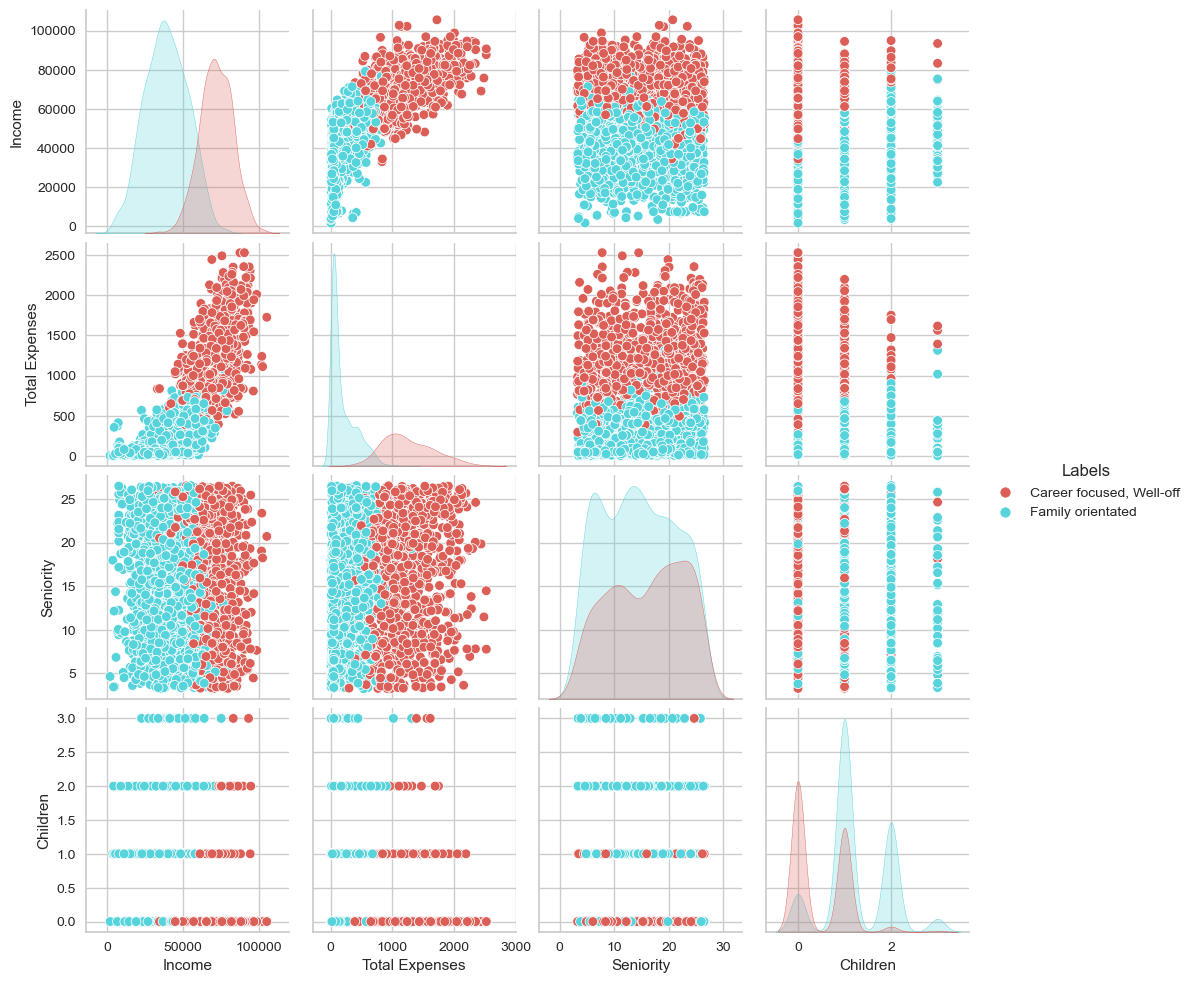

In [33]:
sns.pairplot(segm_pca_kmeans_2_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',2))

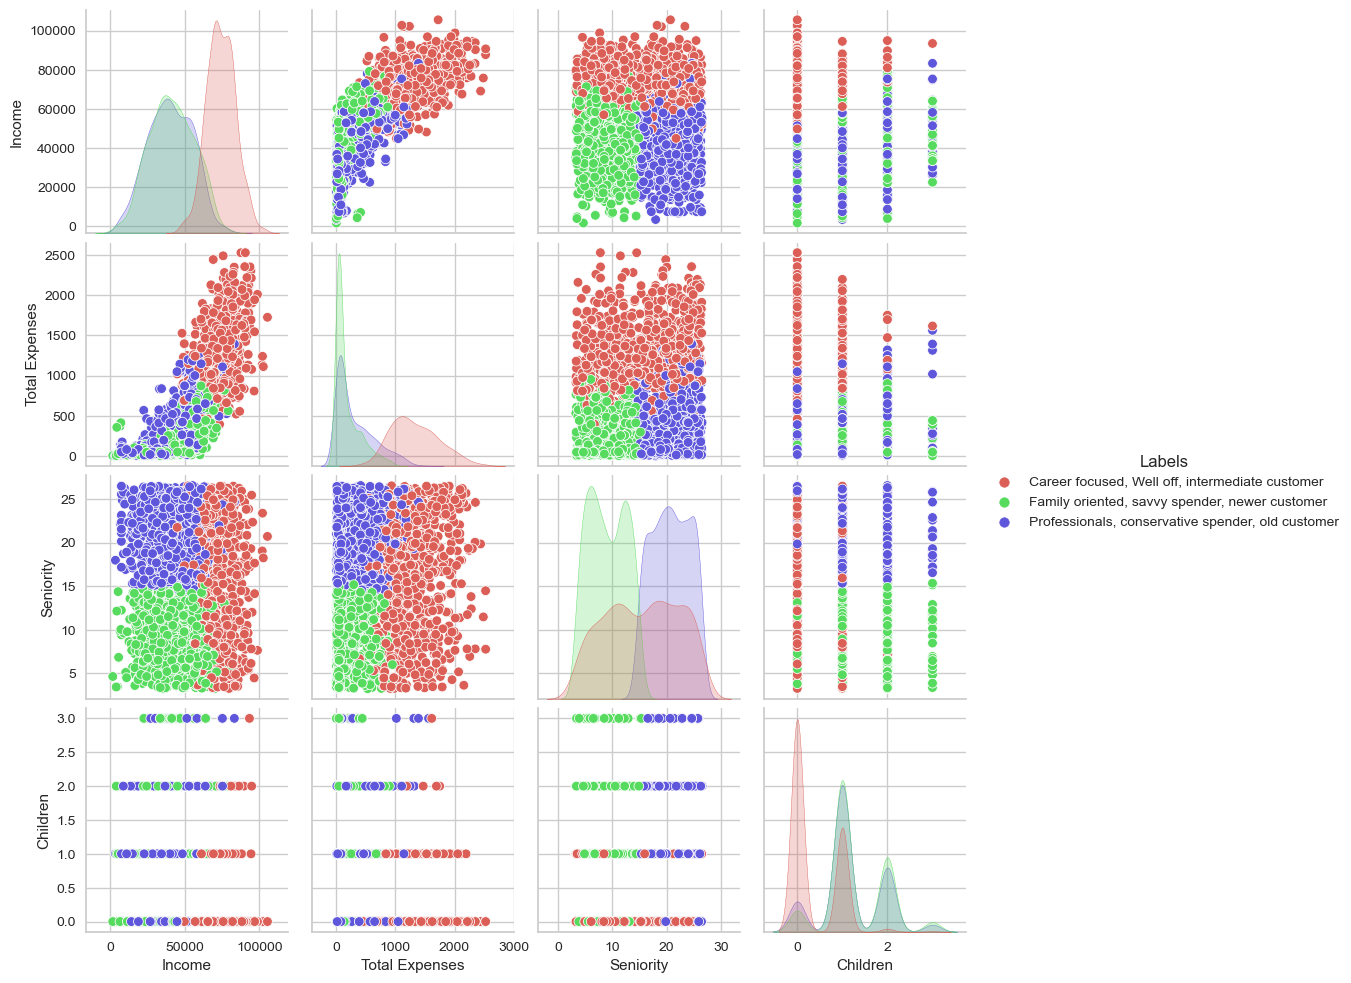

In [34]:
sns.pairplot(segm_pca_kmeans_3_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',3))

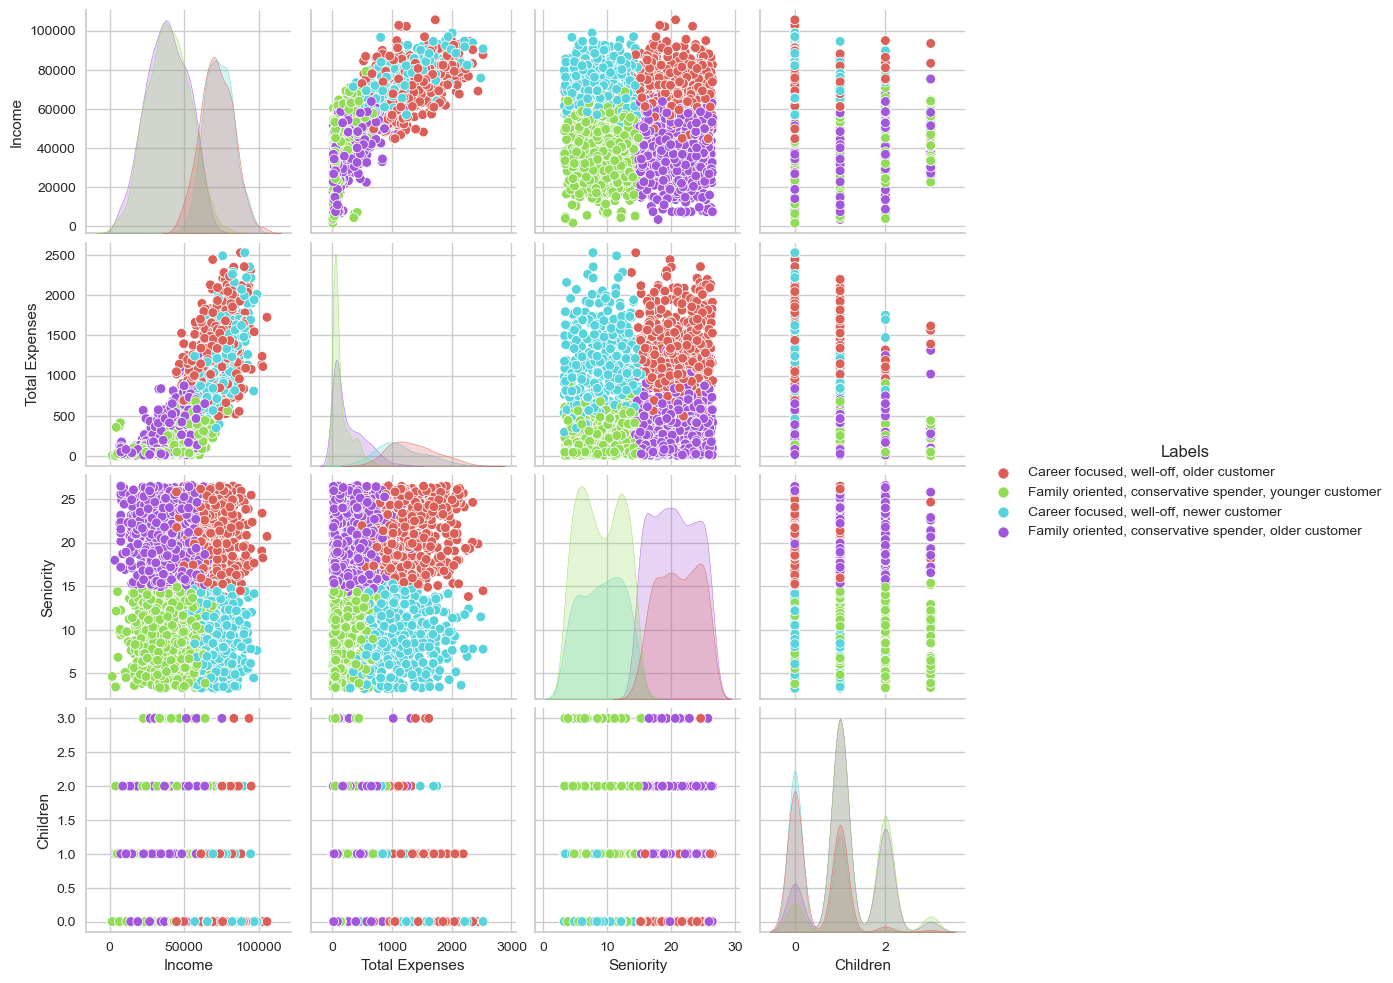

In [35]:
sns.pairplot(segm_pca_kmeans_4_clus, vars=features, hue='Labels', palette=sns.color_palette('hls',4))

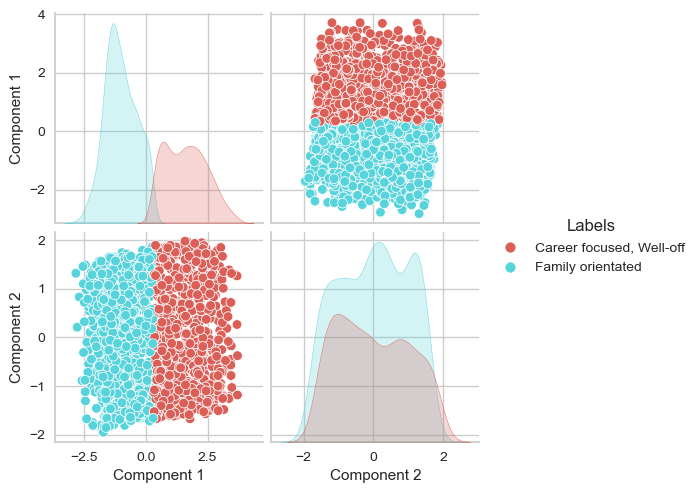

In [36]:
sns.pairplot(segm_pca_kmeans_2_clus, vars=['Component 1', 'Component 2'], hue='Labels', palette=sns.color_palette('hls',2))

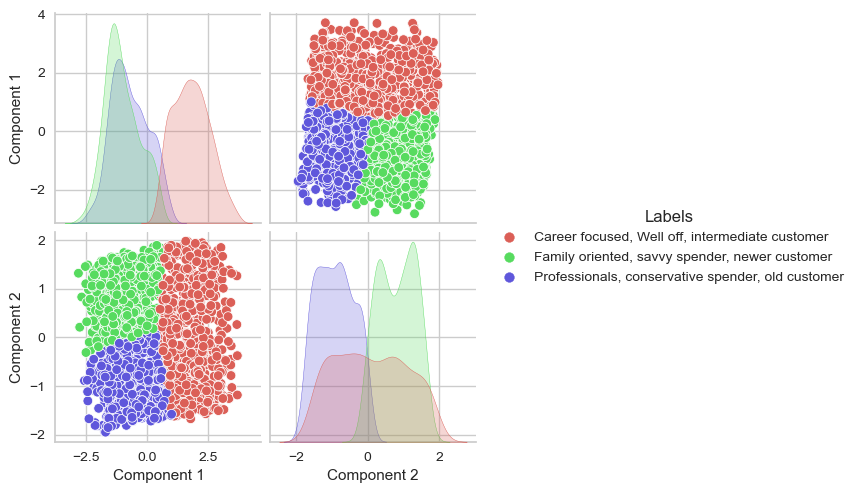

In [37]:
sns.pairplot(segm_pca_kmeans_3_clus, vars=['Component 1', 'Component 2'], hue='Labels', palette=sns.color_palette('hls',3))

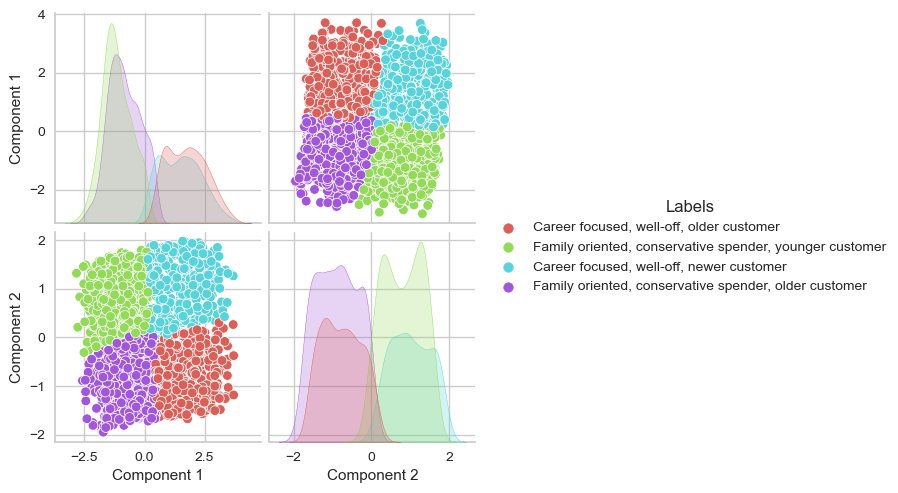

In [38]:
sns.pairplot(segm_pca_kmeans_4_clus, vars=['Component 1', 'Component 2'], hue='Labels', palette=sns.color_palette('hls',4))

# Conclusion

By excluding recency and customer age we get better seperation using PCA combined with k-means than when included. Generalisation is often better, however here we get a model that makes sense with 4 clusters. The 2 cluster model is under constrained.

By choosing 4 clusters and replacing customer age with seniority we almost get a natural seperation into quadrants in both the x-space and the z-space making the model highly interpretable.